# Fetus Brain Detection

2024-05-27 16:18:29.213615: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 16:18:29.259647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2
2024-05-27 16:18:40.699300: I tensorflow/core/c

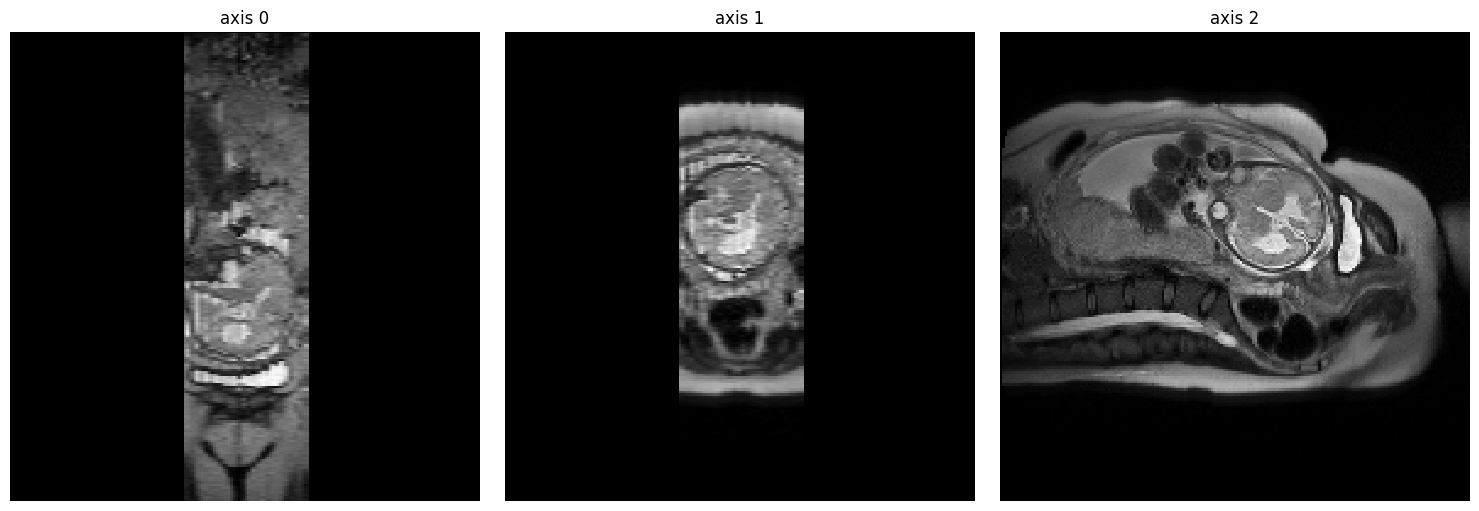

In [1]:
import tensorflow as tf
import numpy as np
from utils import *
import param_3d
import data
import model_3d
from data_3d import *

image_mask_pairs = load_validation_data("validation",192)
a, b = image_mask_pairs[0]

mean_slice_numbers = tuple(np.median(indices) for indices in np.where(b != 0))
ne.plot.volume3D(a,slice_nos=mean_slice_numbers);

In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam


def generate_labels(volume_shape, positions, indices, patch_size, stride, b):
    labels = tf.zeros((len(positions), 1), dtype=tf.float32)

    # Find the bounds of the non-zero elements in the mask
    brain_indices = np.nonzero(b)
    xmin = np.min(brain_indices[0])
    ymin = np.min(brain_indices[1])
    zmin = np.min(brain_indices[2])
    xmax = np.max(brain_indices[0])
    ymax = np.max(brain_indices[1])
    zmax = np.max(brain_indices[2])

    # Generate labels for each position
    for pos, index in zip(positions, indices):
        x1, y1, z1, x2, y2, z2 = pos
        if (x1 >= xmin and y1 >= ymin and z1 >= zmin and
                x2 <= xmax  and y2 <= ymax and z2 <= zmax):
            labels = tf.tensor_scatter_nd_update(
                labels,
                indices=[[index, 0]],
                updates=[1]
            )

    return labels
    
def gen_fragments(input_volume, positions, patch_size):
    fragments = []
    labels = generate_labels((192,192,192), positions, indices, param_3d.img_size_24, 4, b)

    for i in range(len(positions)):
        x1, y1, z1, x2, y2, z2 = positions[i]
        fragment = input_volume[0, x1:x2, y1:y2, z1:z2, :]
        yield fragment[None,...] , labels[i][None,...]
        
# [pos_db_12, _, _] = load_db_detect_train_from_generator(a, b, param_3d.img_size_12)
positions, indices = generate_position_map((192,192,192), param_3d.img_size_24, 4)
labels = generate_labels((192,192,192), positions, indices, param_3d.img_size_24, 4, b)

# # # Prepare the input volume for fragment extraction
input_volume = a[None, ..., None]


gen = gen_fragments(input_volume, positions, param_3d.img_size_24)
fragment , label = next(gen)


# # Compile and train the model
model = model_3d.detect_24Net()

learning_rate = 0.001  # You can adjust this value as needed

model.compile(
    optimizer=Adam(learning_rate=param_3d.lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(gen, epochs=10, batch_size=32)


NameError: name 'b' is not defined

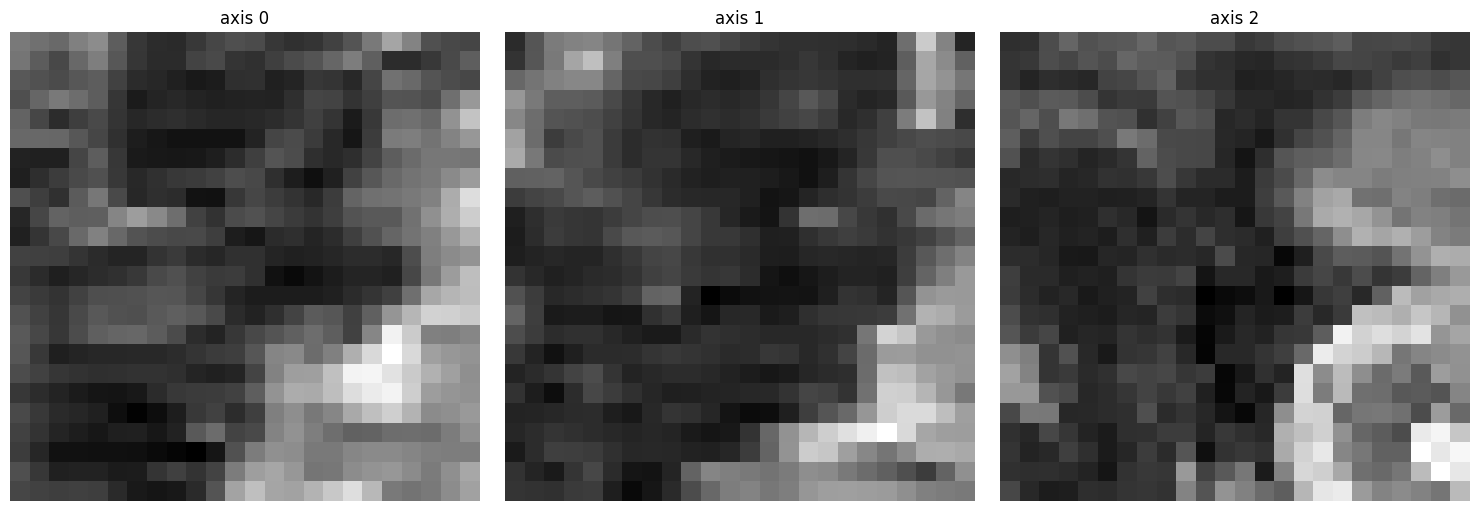

In [15]:
x1, y1, z1, x2, y2, z2 = positions[26850]
box = np.zeros((192, 192, 192), dtype=int)
box[x1:x2+1, y1:y2+1, z1:z2+1] = 1

mean_slice_numbers = tuple(np.median(indices) for indices in np.where(box != 0))
ne.plot.volume3D(fragment)

# Generator

In [1]:
import pathlib
import json
import nibabel as nib
import numpy as np
import tensorflow as tf
from utils import *
import param_3d


feta = pathlib.Path('feta_resized_192')
with open("params_192.json", "r") as json_file:
    config = json.load(json_file)

feta_files = list(feta.glob('*.nii.gz'))
# feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]
# brain_maps = feta_label_maps
# brain_maps = [tf.cast(brain, tf.uint8) for brain in brain_maps]

brain_maps = [np.uint8(sf.load_volume(str(file_path)).reshape([param_3d.img_size_24,]*3).data) for file_path in feta_files]


model_feta_config = config["feta_24"]
model_shapes_config = config["shapes"]
model3_config = config["labels_to_image_model_24"]
model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
model_feta_config["in_shape"]=[ param_3d.img_size_24, param_3d.img_size_24, param_3d.img_size_24]
model3_config["in_shape"]=[ param_3d.img_size_24, param_3d.img_size_24, param_3d.img_size_24]
model_shapes_config["in_shape"]=[ param_3d.img_size_24, param_3d.img_size_24, param_3d.img_size_24]

model_feta = create_model(model_feta_config)
model_shapes = create_model(model_shapes_config)


positions, indices = generate_position_map((192,192,192), param_3d.img_size_24, 4)
labels_to_image_model = create_model(model3_config)

gen=generator_brain_window_Net(brain_maps,param_3d.img_size_24)

2024-06-07 11:38:35.152918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2
2024-06-07 11:38:43.175459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 496 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


(None, 96, 96, 96, 1)
(None, 96, 96, 96, 1)
(48, 48, 48, 3)
(None, 96, 96, 96, 1)
(None, 96, 96, 96, 1)
(None, 96, 96, 96, 1)
Tensor("perlin_noise_1/strided_slice:0", shape=(4,), dtype=int32)
(None, 96, 96, 96, 1)
(None, 96, 96, 96, 1)
(None, 96, 96, 96, 1)
(48, 48, 48, 3)
(None, 96, 96, 96, 1)
(None, 96, 96, 96, 1)
(None, 96, 96, 96, 1)
Tensor("perlin_noise_3/strided_slice:0", shape=(4,), dtype=int32)
(None, 96, 96, 96, 1)
(None, 96, 96, 96, 1)
(None, 96, 96, 96, 1)
(48, 48, 48, 3)
(None, 96, 96, 96, 1)
(None, 96, 96, 96, 1)
(None, 96, 96, 96, 1)
Tensor("perlin_noise_5/strided_slice:0", shape=(4,), dtype=int32)
(None, 96, 96, 96, 1)


(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 6 7]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


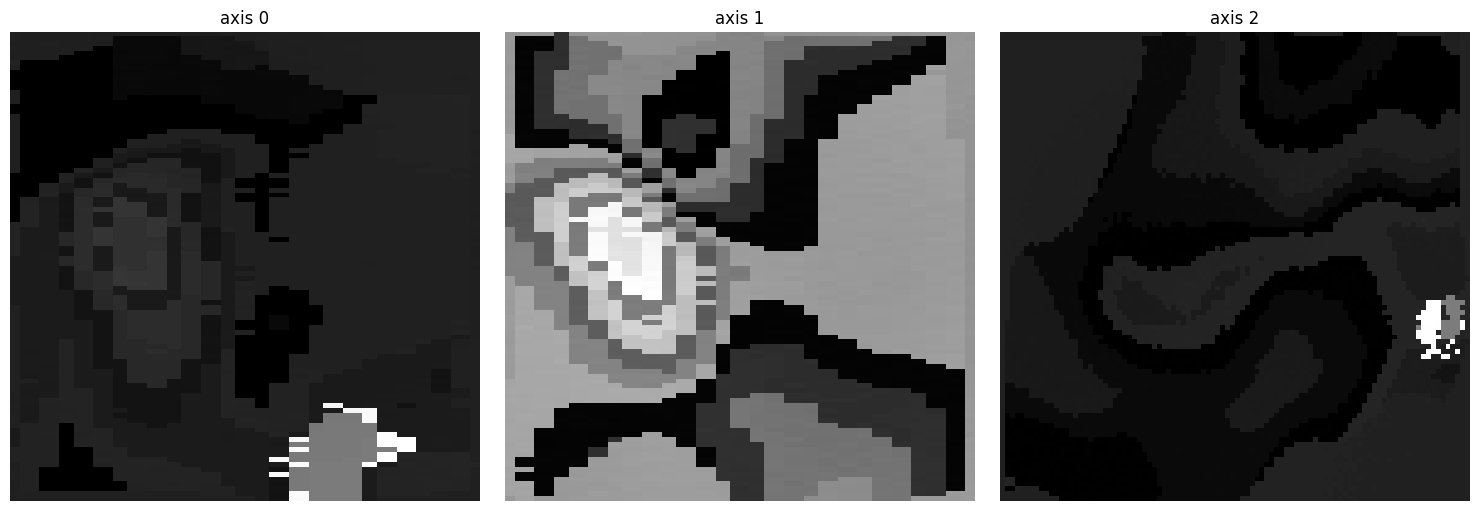

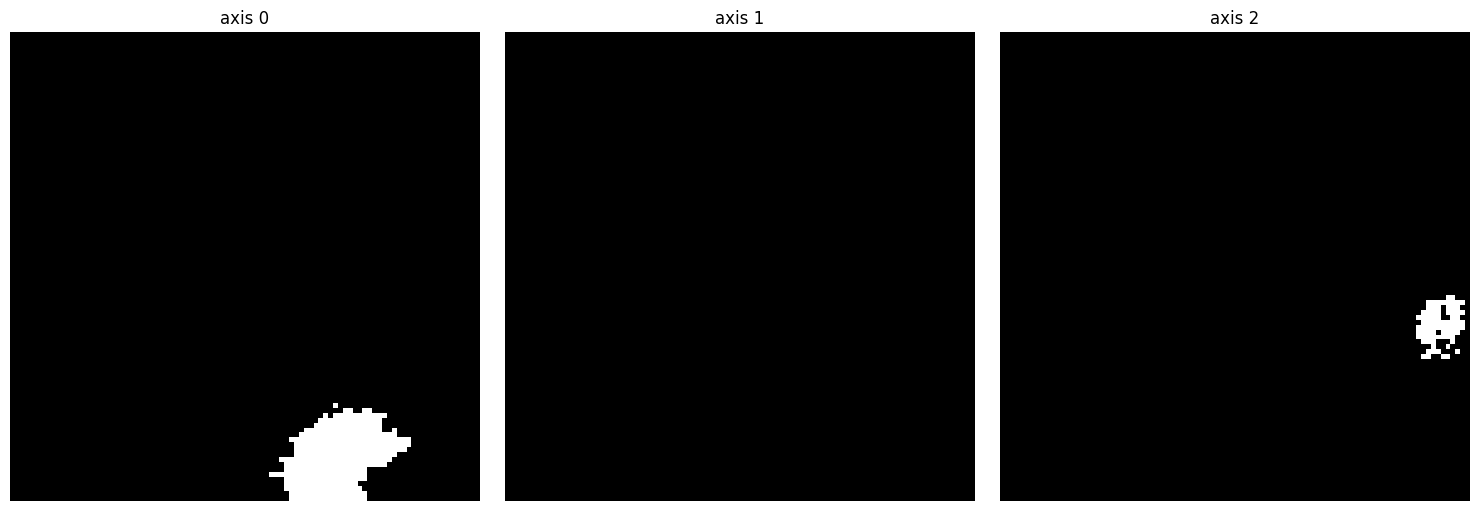

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


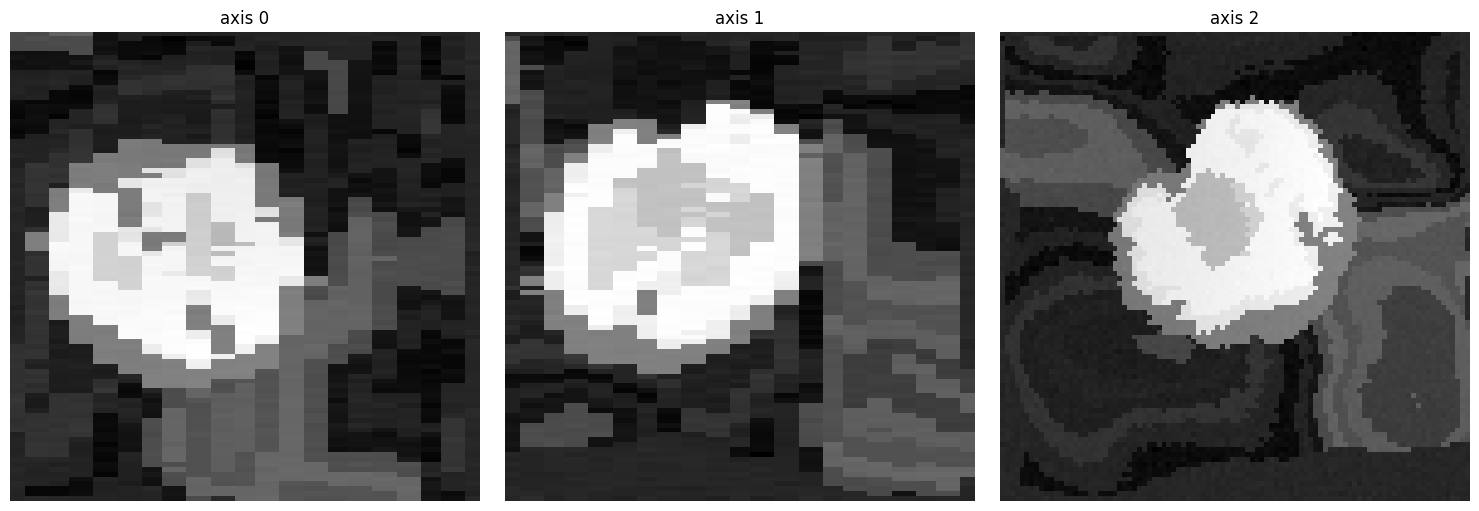

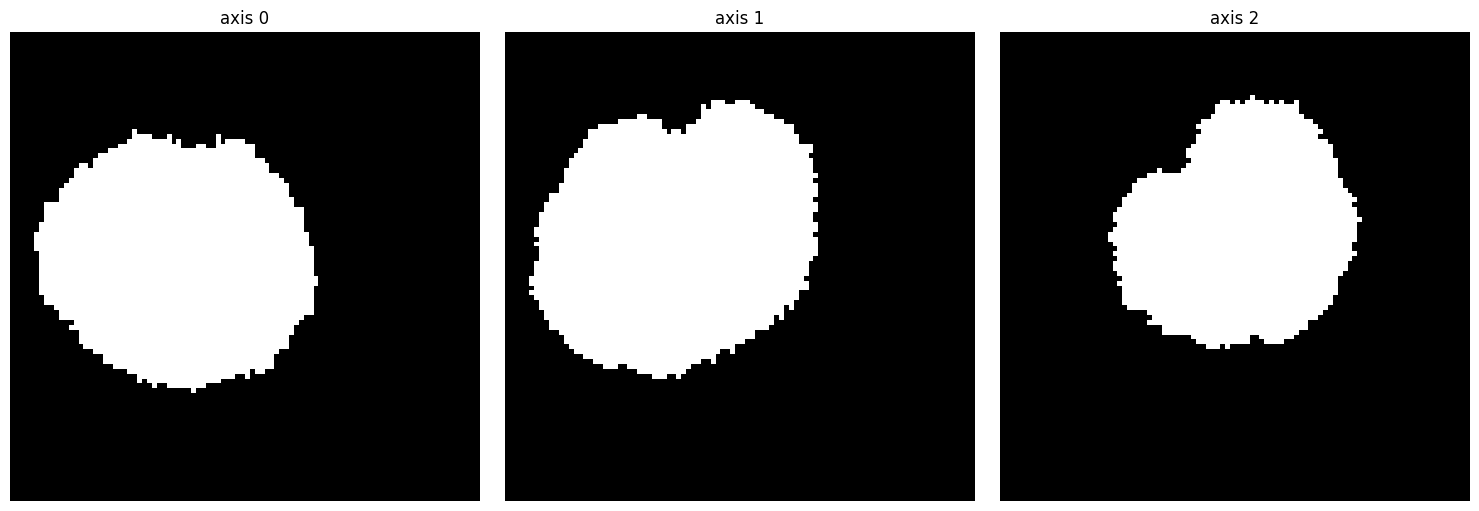

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


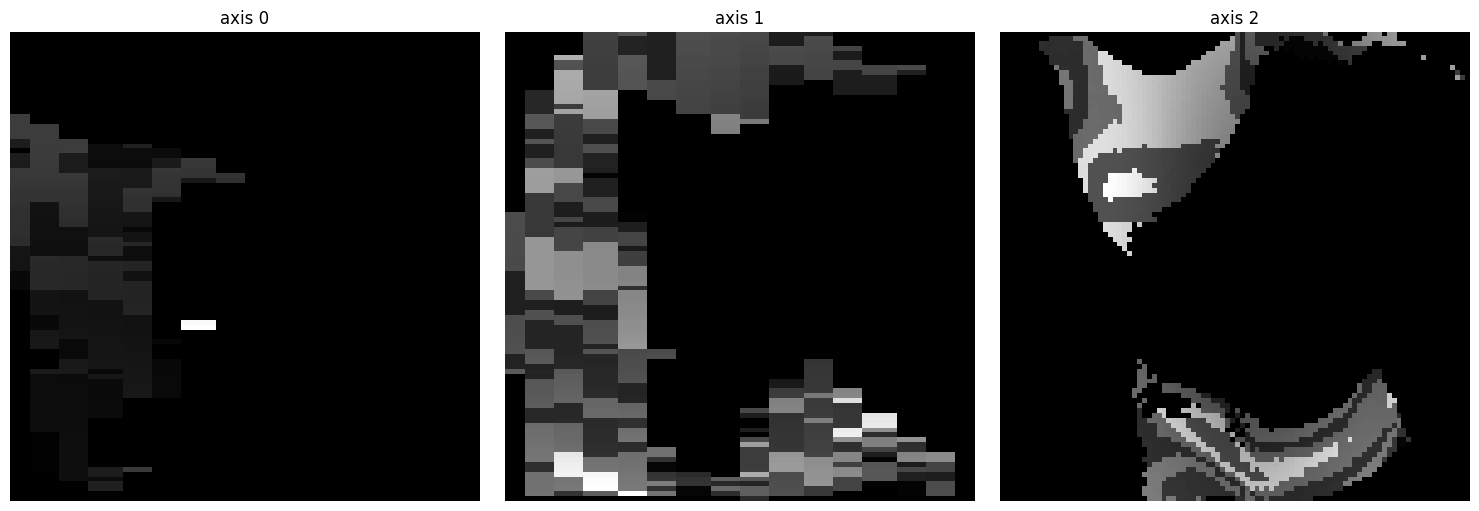

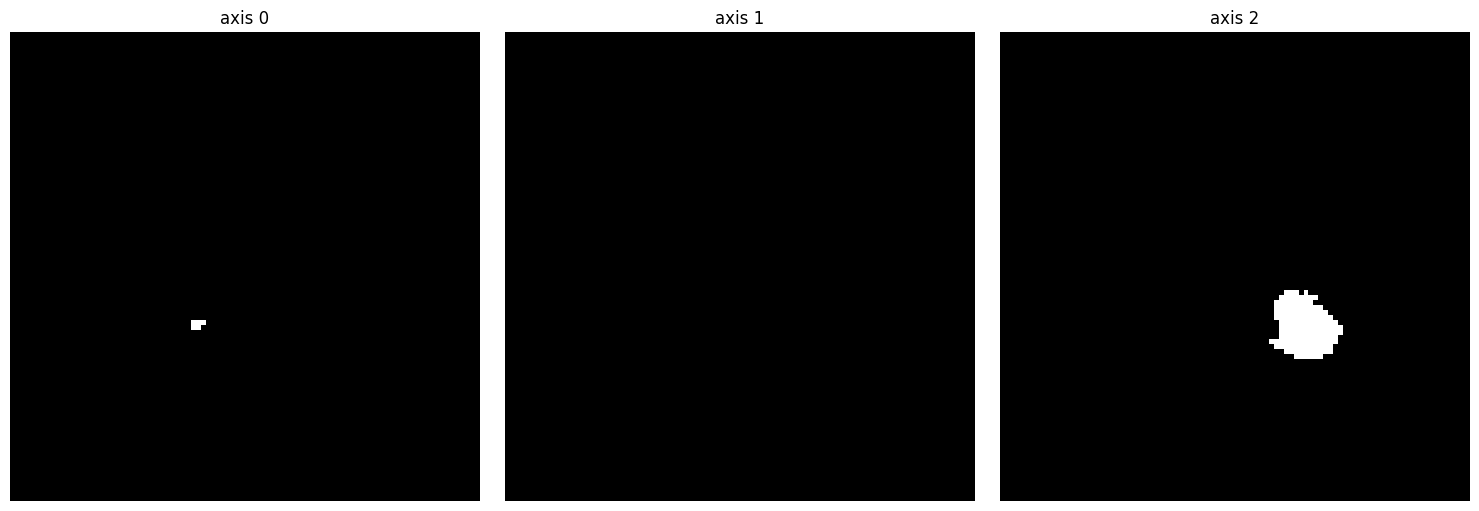

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


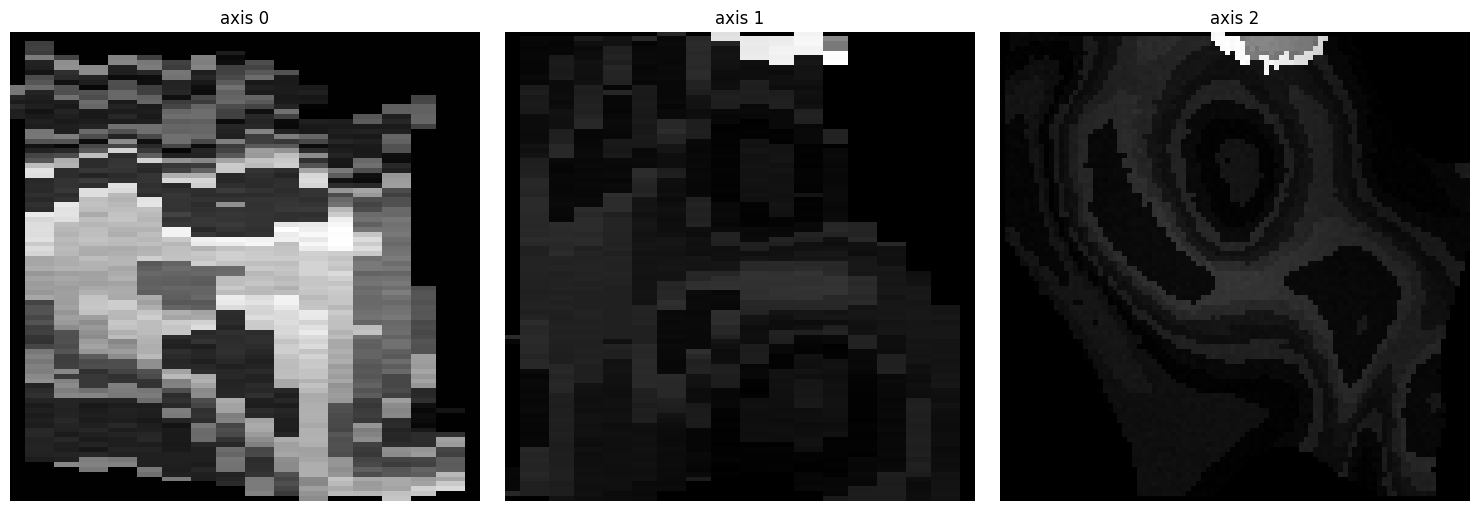

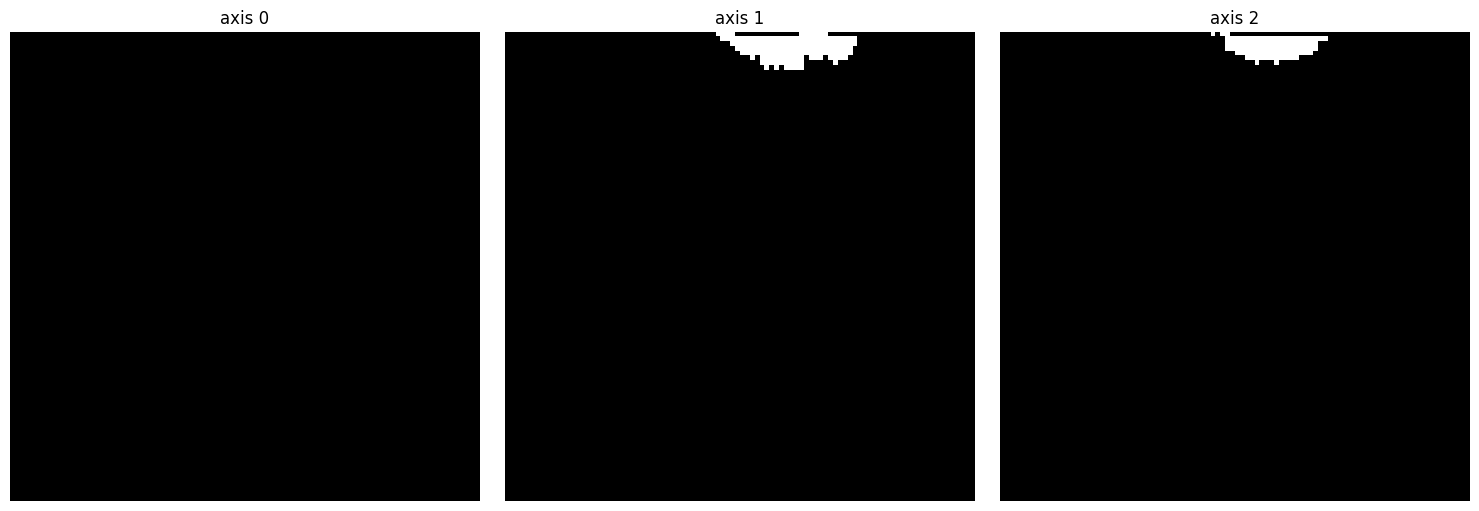

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


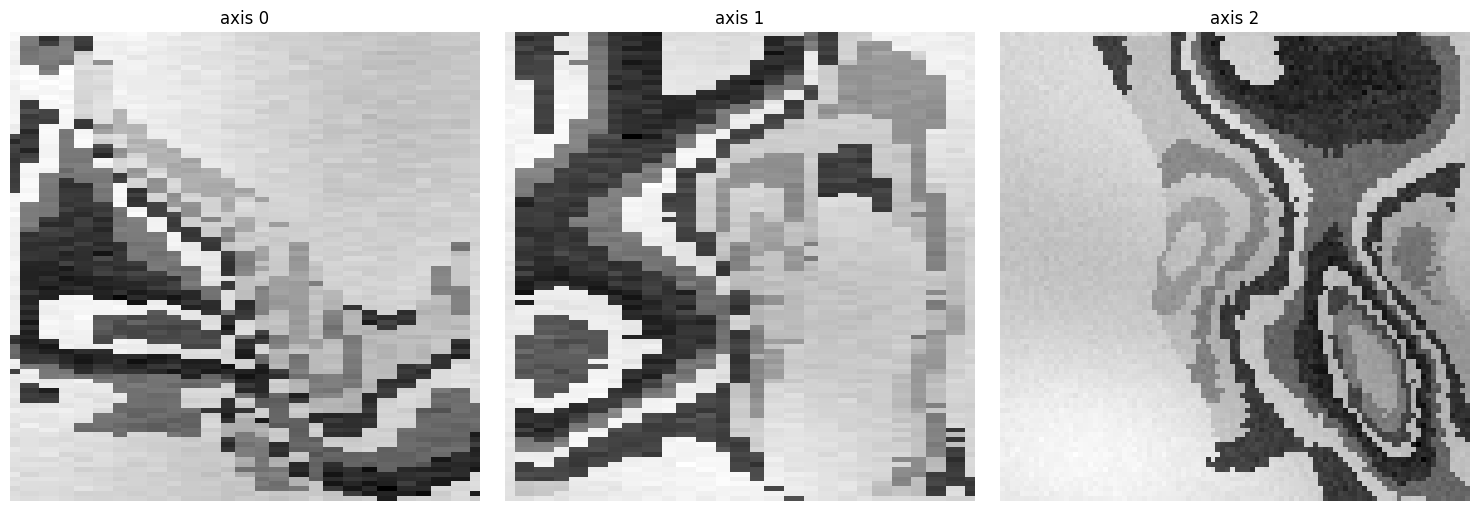

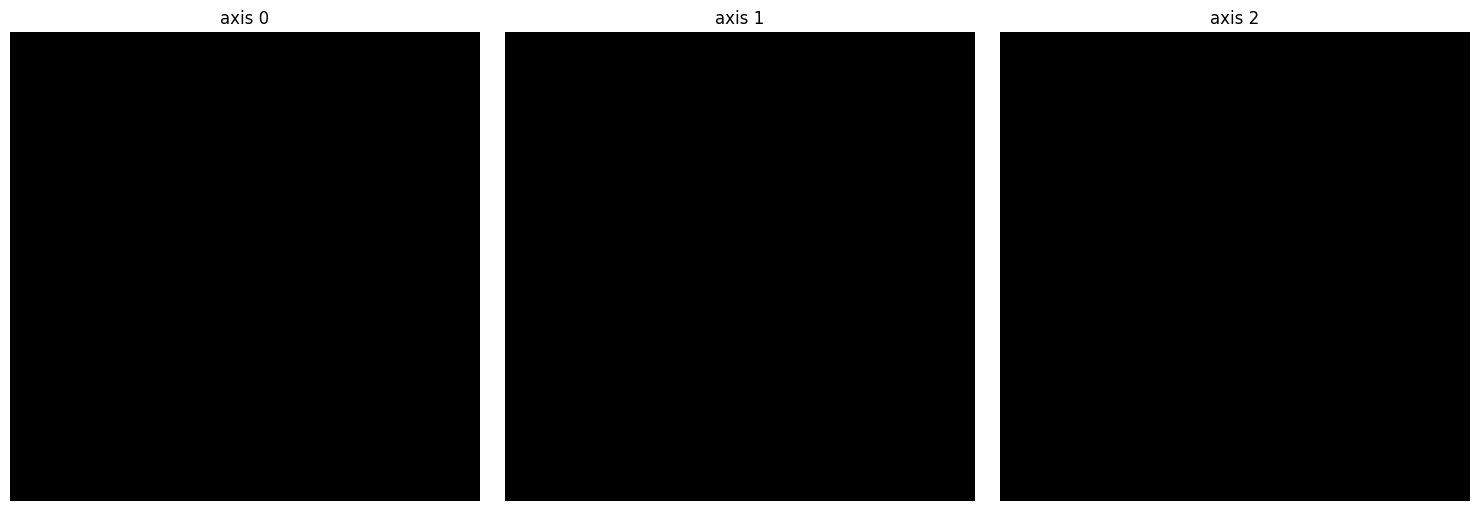

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


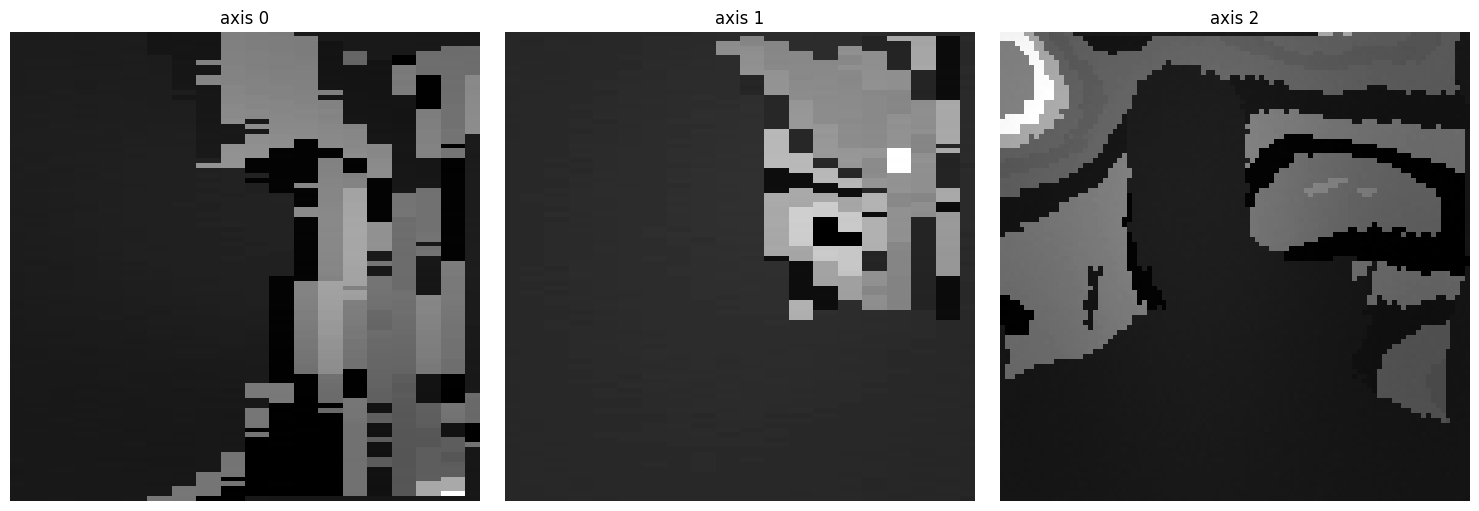

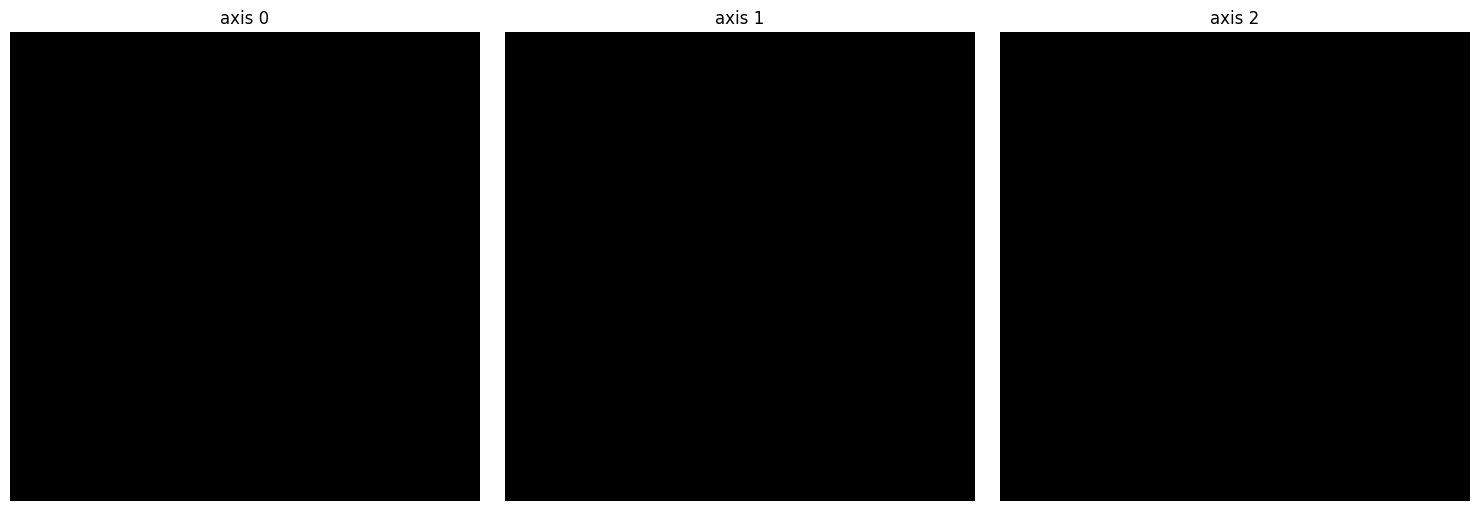

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


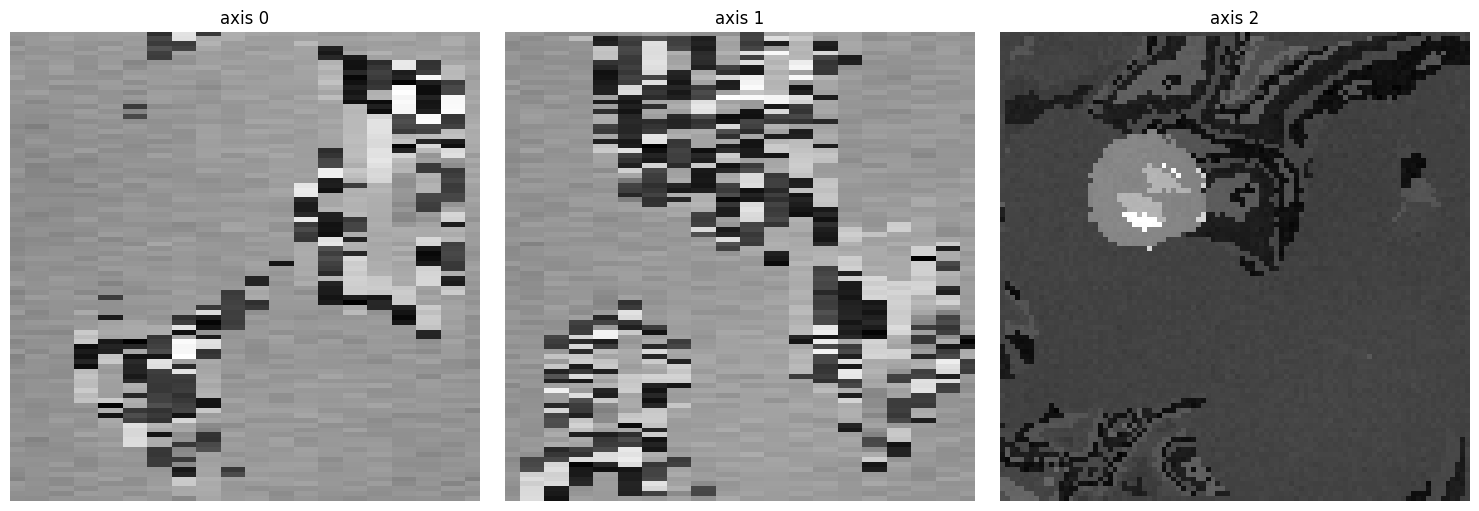

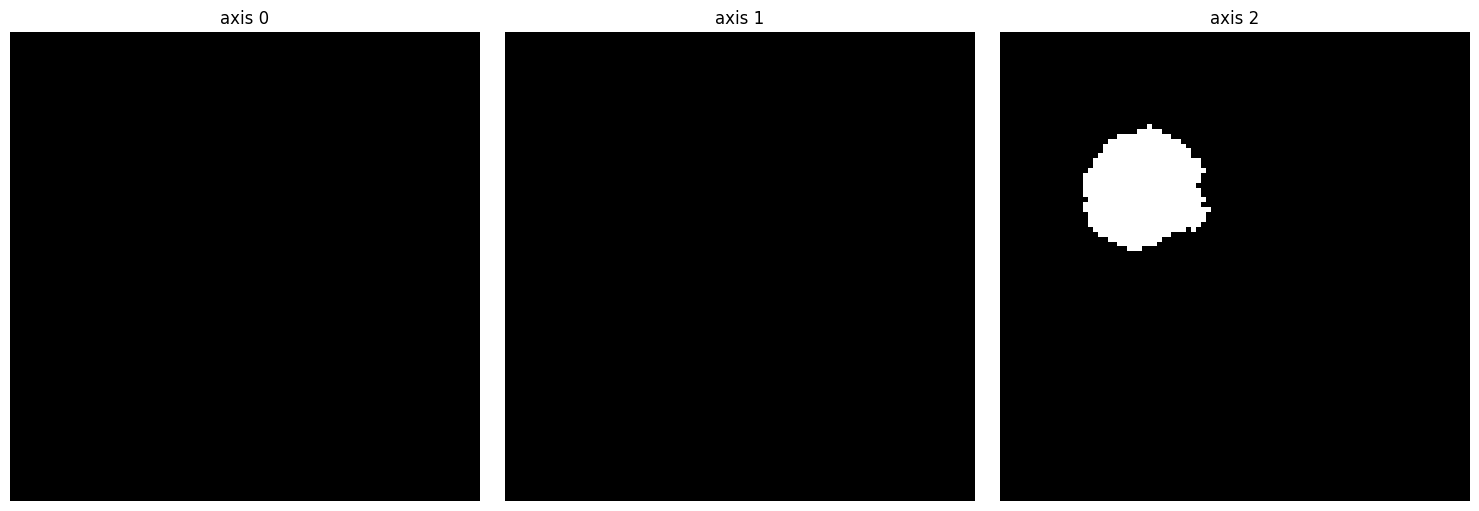

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


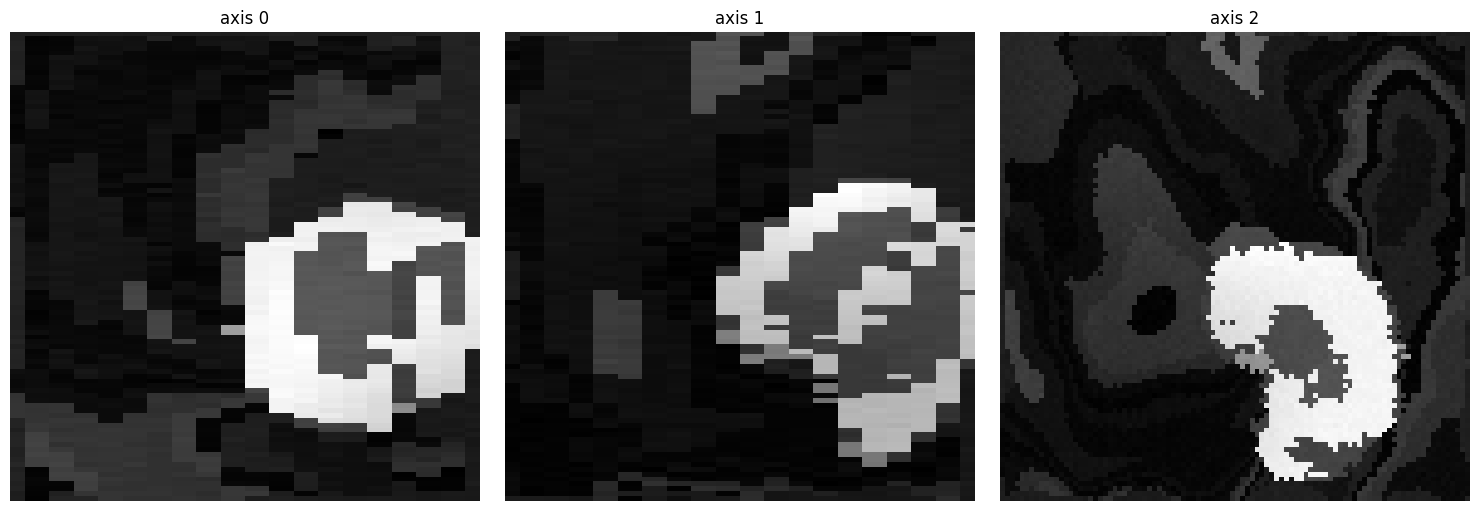

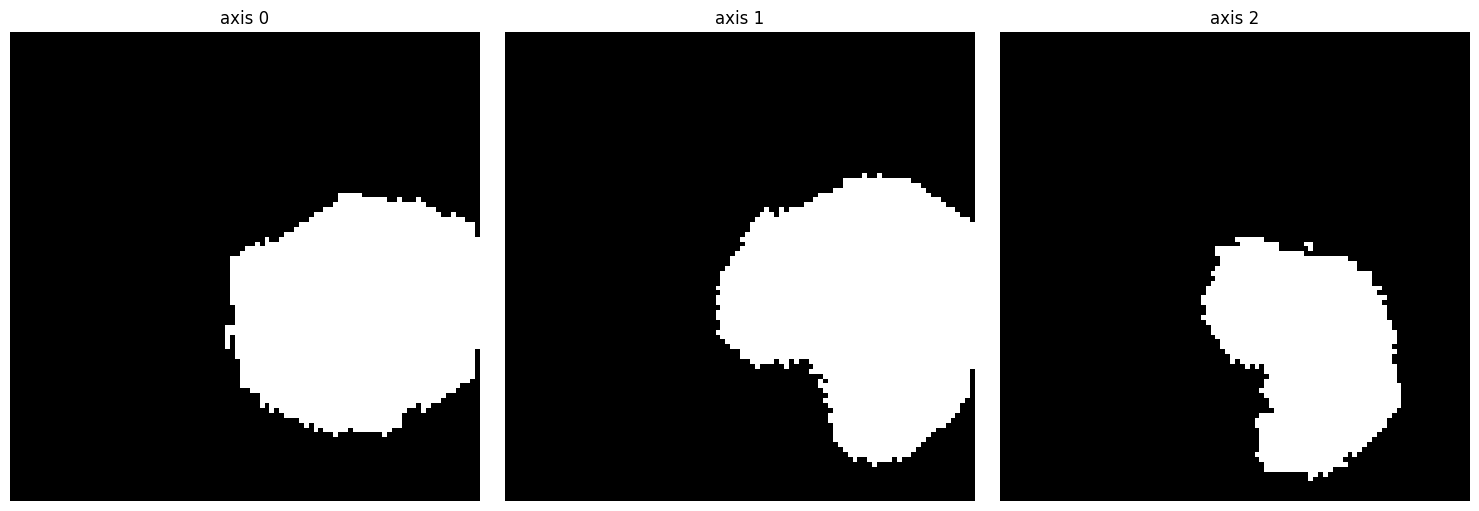

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


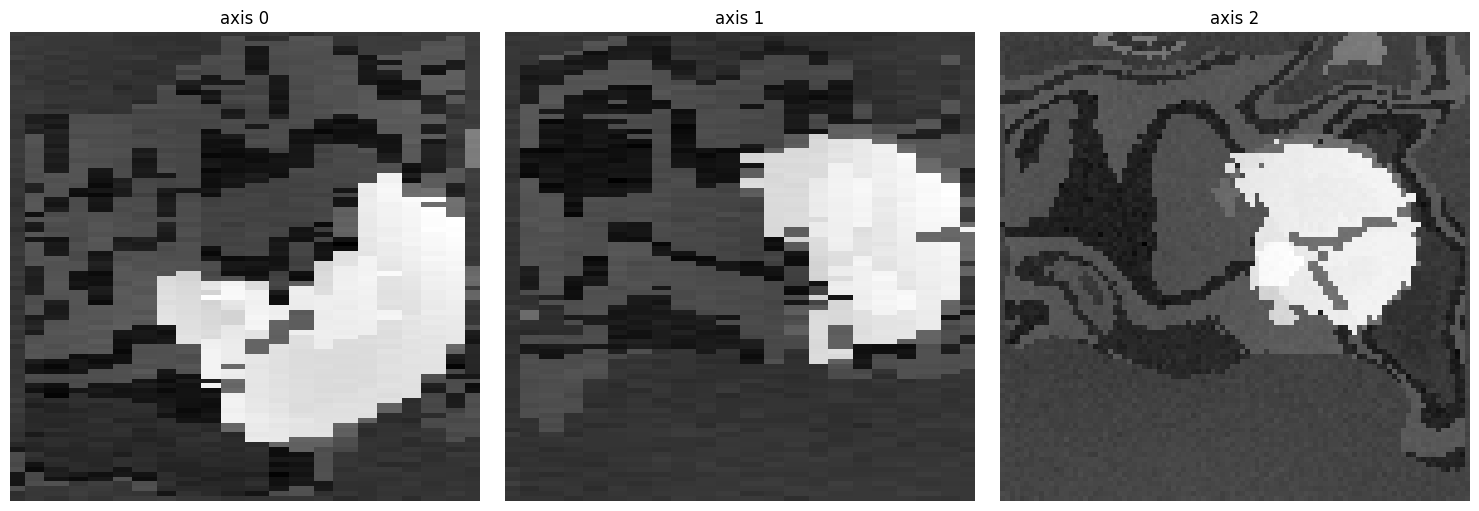

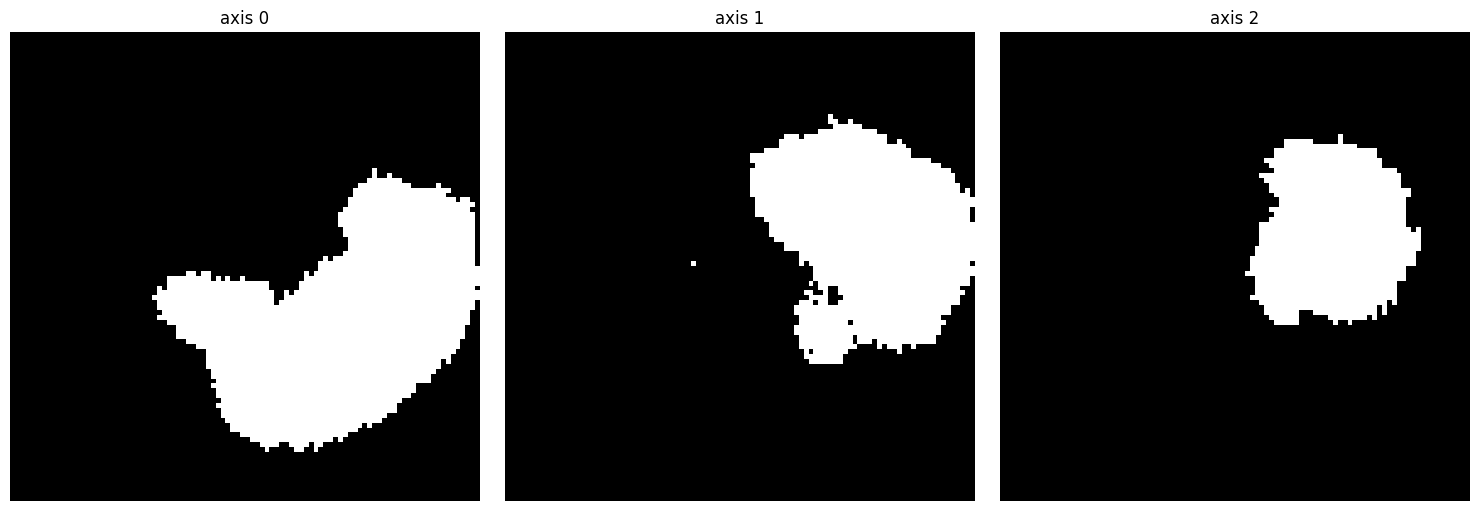

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


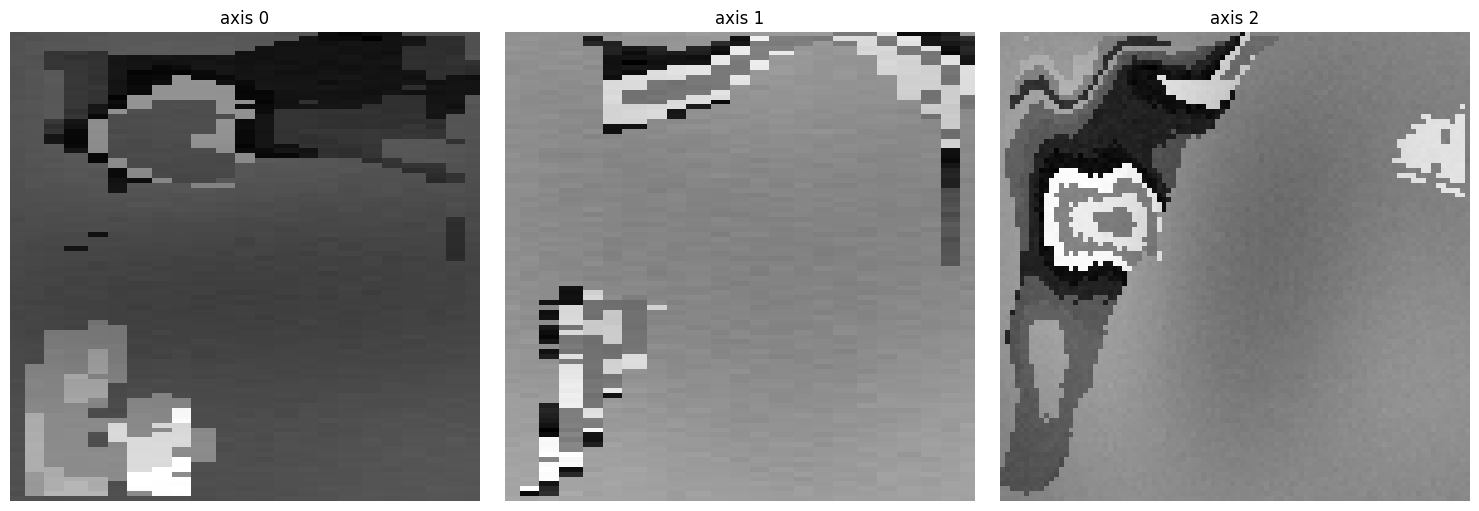

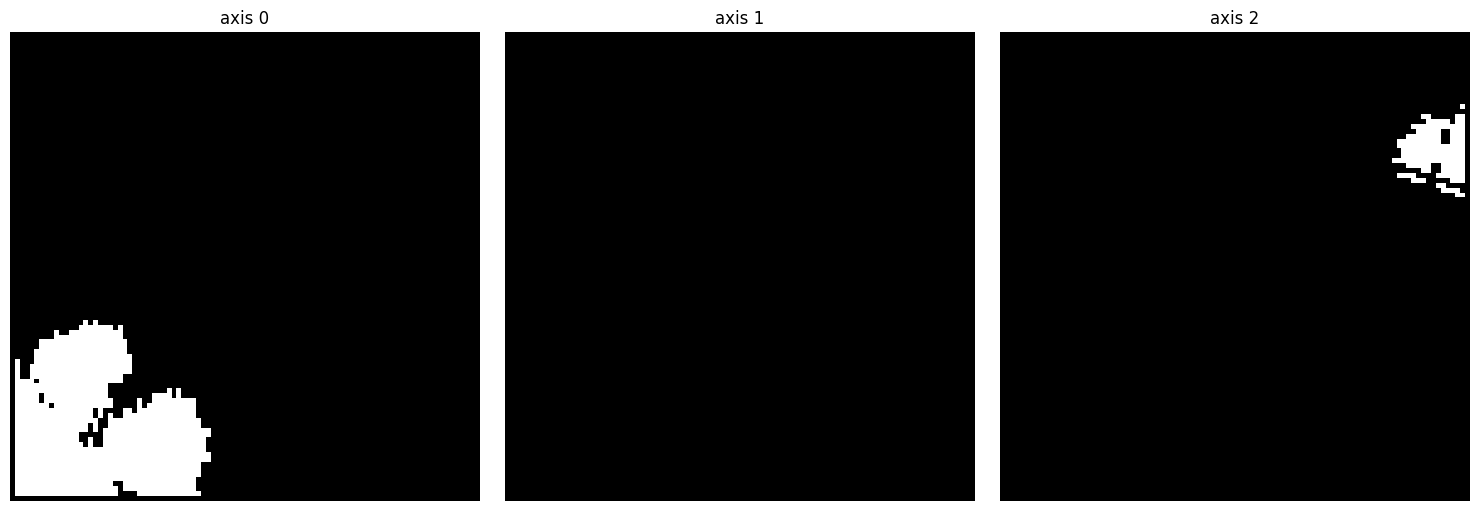

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 6 7]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


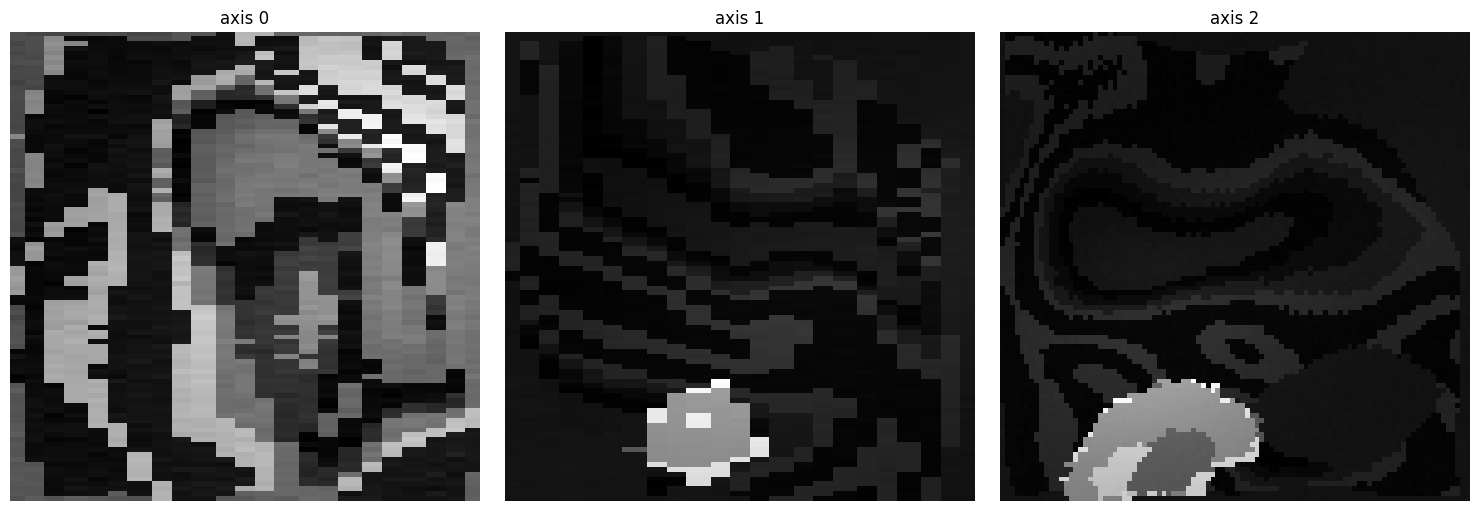

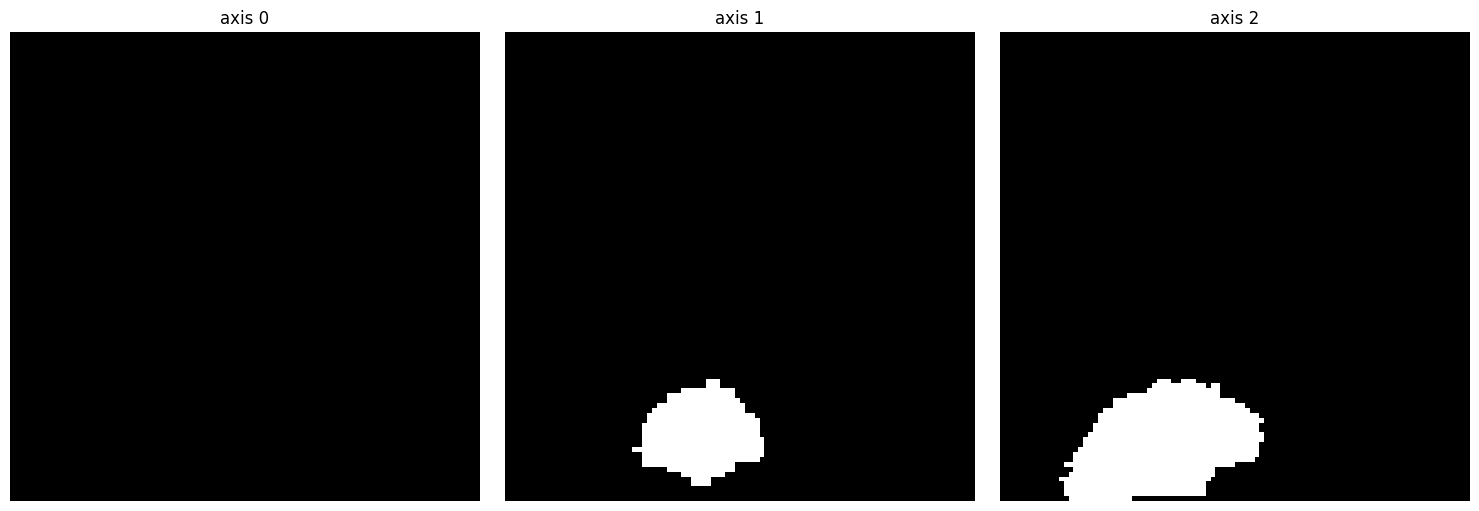

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


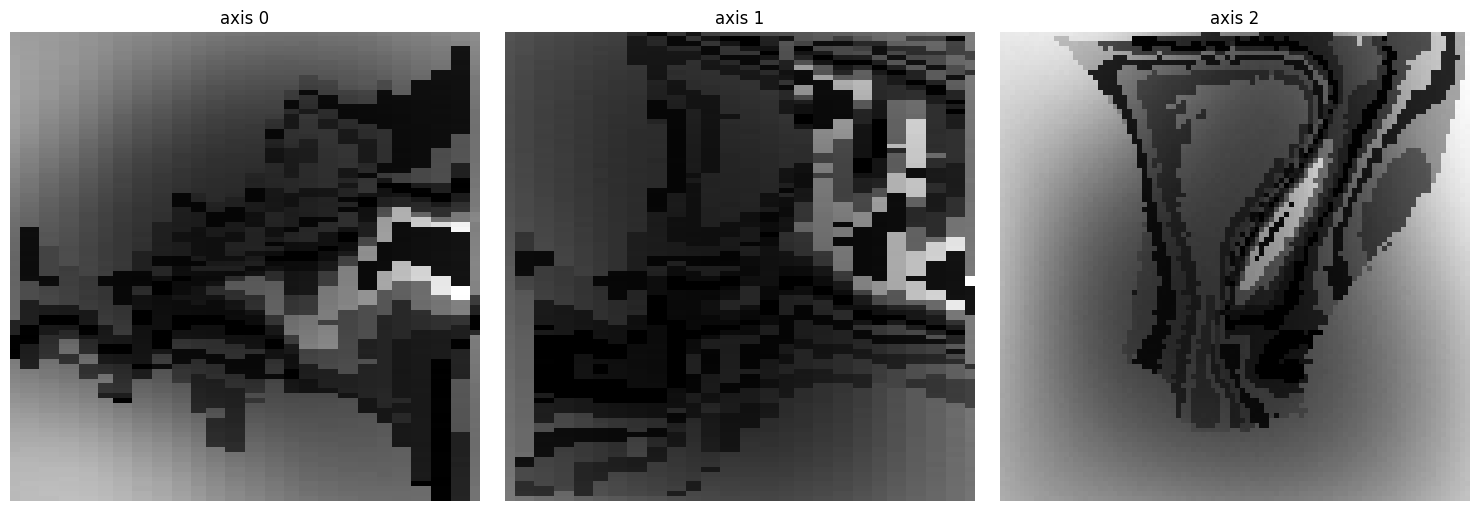

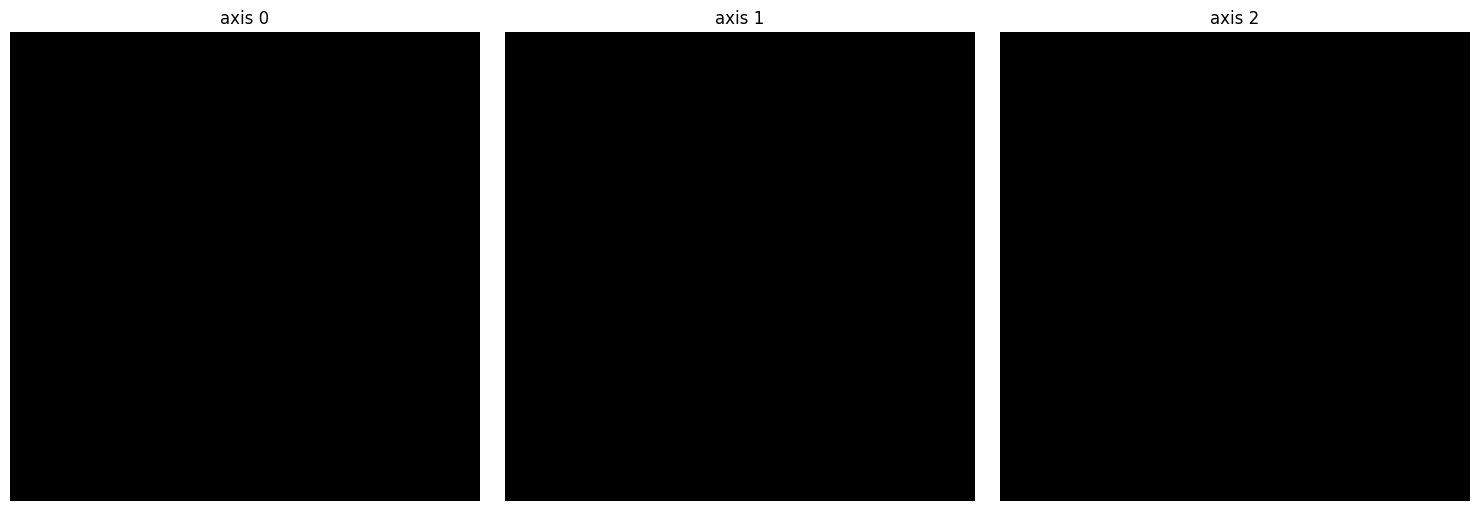

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


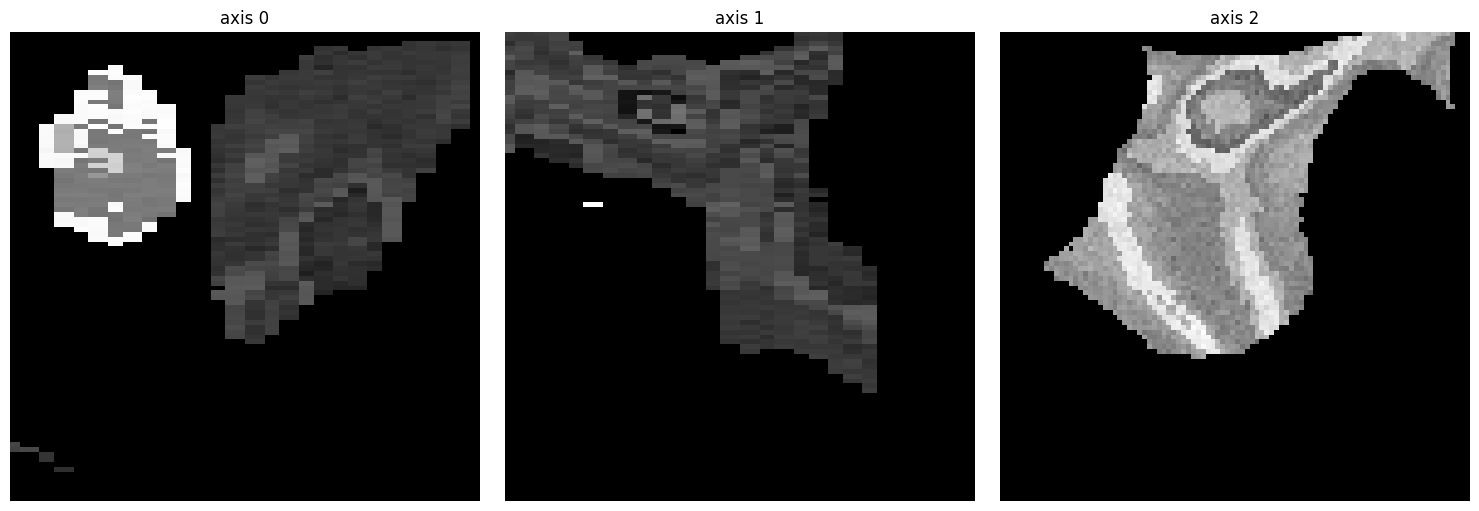

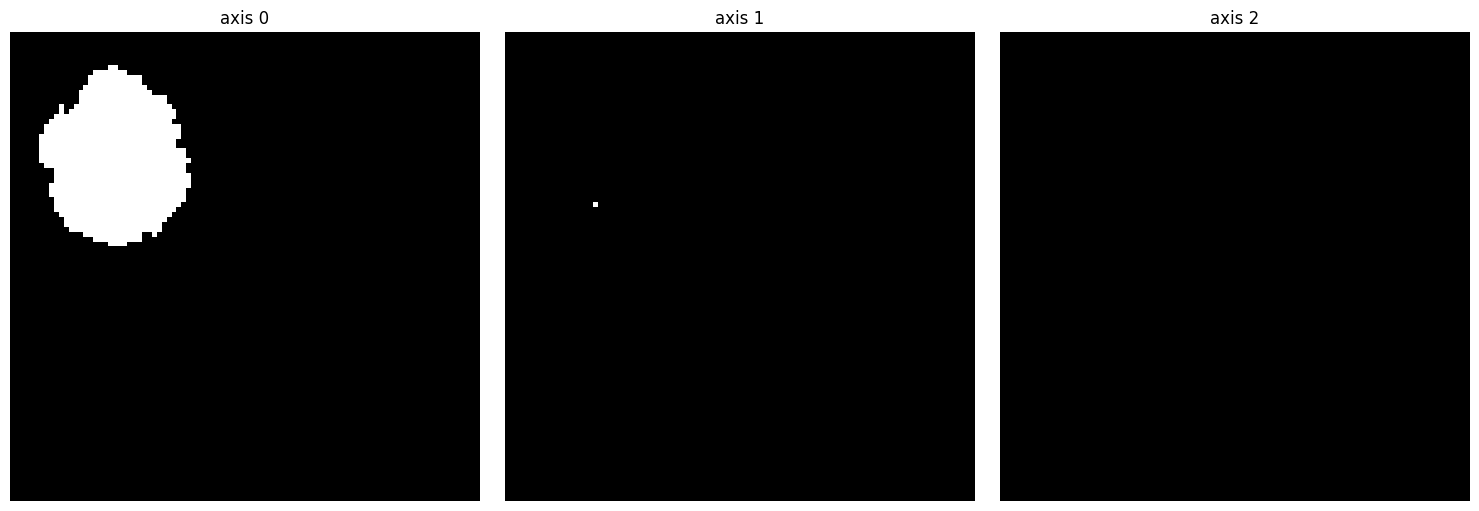

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 6]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


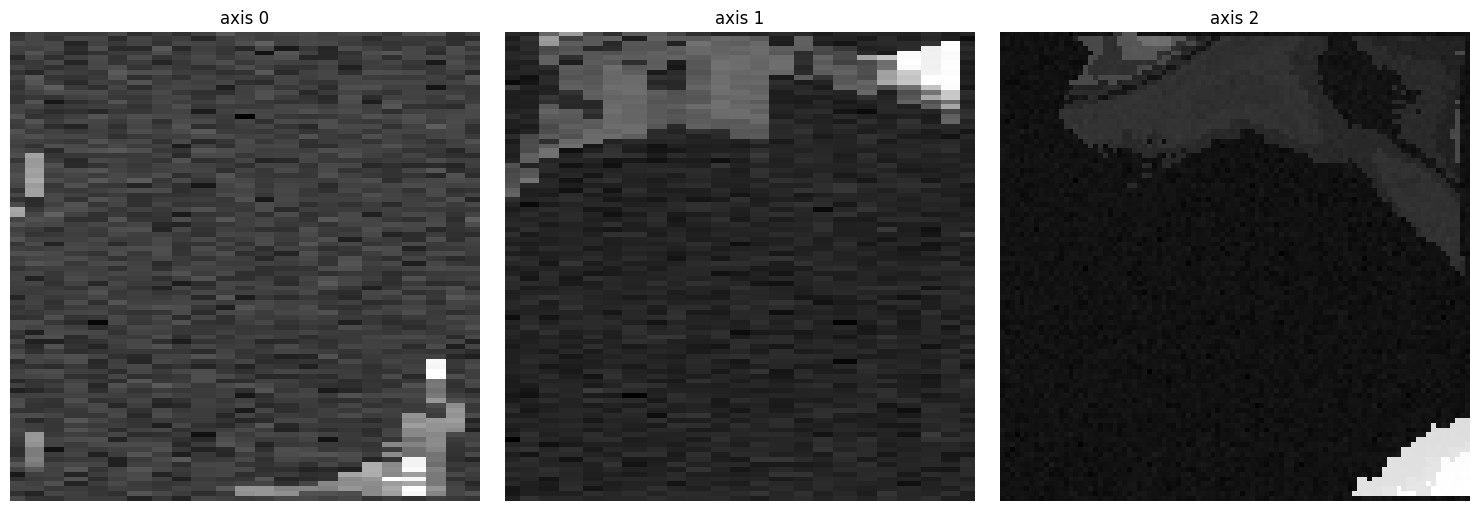

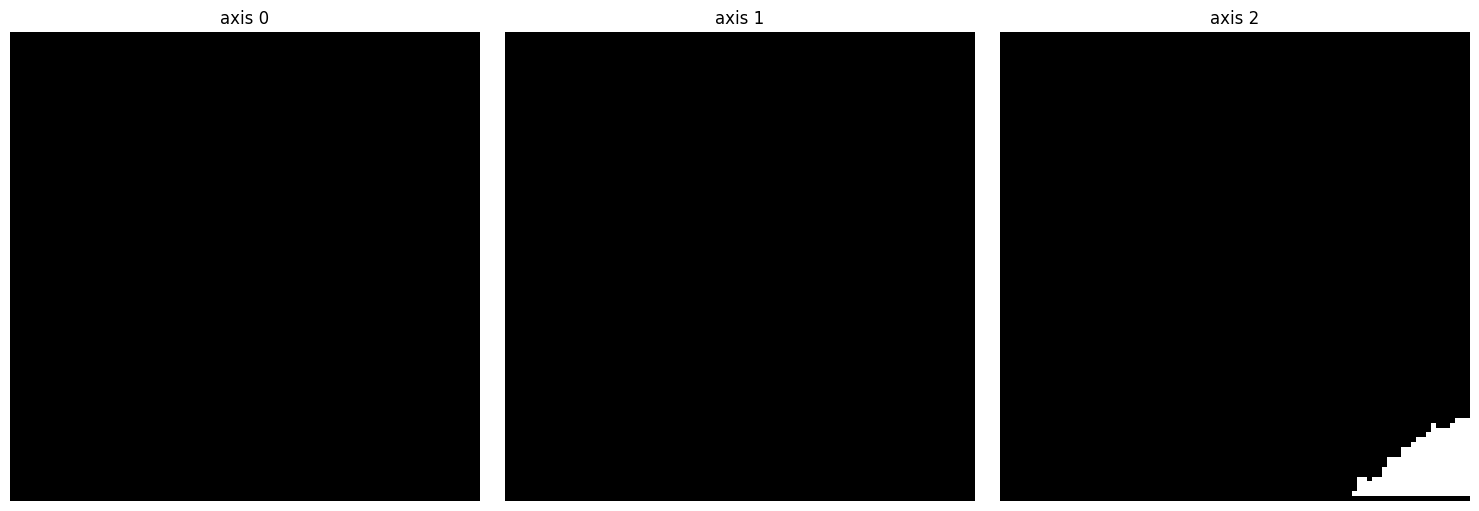

(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 6]
(96, 96, 96, 1)
(96, 96, 96, 3)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(48, 48, 48, 3)
tf.Tensor([96 96 96  1], shape=(4,), dtype=int32)
(1, 96, 96, 96, 1)


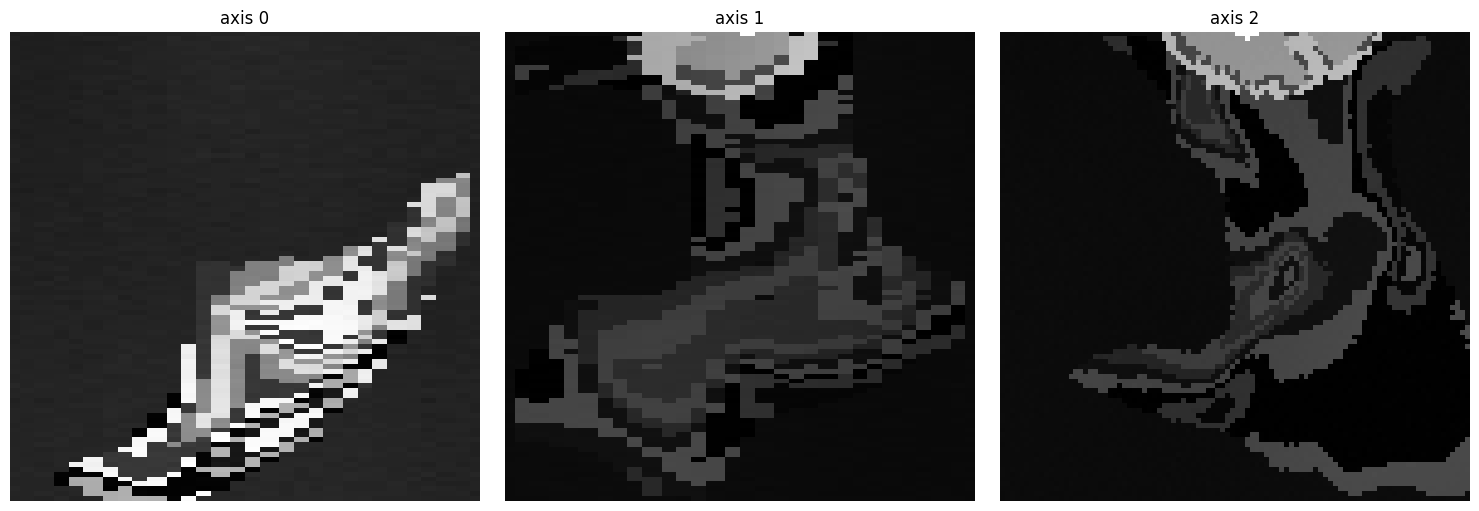

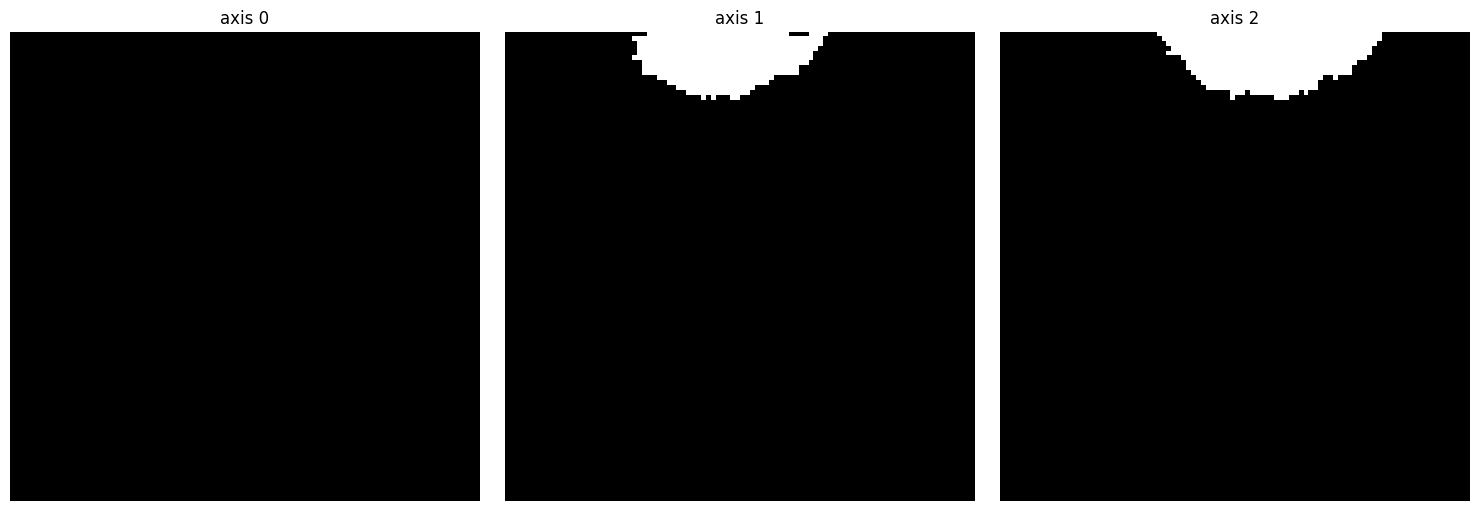

In [3]:
from scipy.ndimage import measurements
def shift_non_zero_elements(bg, shift_value):
    non_zero_mask = tf.not_equal(bg, 0)
    shifted_non_zero_elements = tf.where(non_zero_mask, bg + shift_value, bg)
    return shifted_non_zero_elements
    
j=0
for i in range(9000):
    fragment = next(gen)

    _, fg = model_feta(fragment)

    print("fg",np.unique(fg))
    
  
    shapes = draw_shapes(shape = (param_3d.img_size_24,)*3)

    shapes = tf.squeeze(shapes)
    shapes = tf.cast(shapes, tf.uint8)
    
    _, bg = model_shapes(shapes[None,...,None])
    bg = shift_non_zero_elements(bg,8)    
    result = fg + bg * tf.cast(fg == 0,tf.int32)
    
    generated_img, y = labels_to_image_model(result)

    print(generated_img.shape)
    z=np.argmax(y,axis=-1)
    ms = np.mean(np.column_stack(np.nonzero(z[0])), axis=0).astype(int)

    ne.plot.volume3D(generated_img)#,slice_nos=ms);
    ne.plot.volume3D(np.argmax(y,axis=-1))#,slice_nos=ms);

    j=j+1
    if j==15:
        break